In [1]:
!pip install pmdarima

In [39]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings

In [40]:
from math import sqrt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [41]:
warnings.filterwarnings("ignore")

In [42]:
df = pd.read_csv('../data/sensor1.csv')

In [43]:
df = df.dropna()

In [44]:
units_dict = {}

for col in df.columns[1:]:
    values = []
    units = set()
    for val in df[col]:
        value, unit = val.split()
        values.append(value)
        units.add(unit)
    new_col_name = f"{col} ({units.pop()})"
    df.rename(columns={col: new_col_name}, inplace=True)
    df[new_col_name] = pd.to_numeric(values)
    units_dict[col] = units

In [45]:
df['Time'] = pd.to_datetime(df['Time'])

In [46]:
df.index = df['Time']
df.drop(columns=['Time'], inplace=True)

In [47]:
df = df.sort_index()

In [48]:
temperature = df["CO2 (ppm)"]

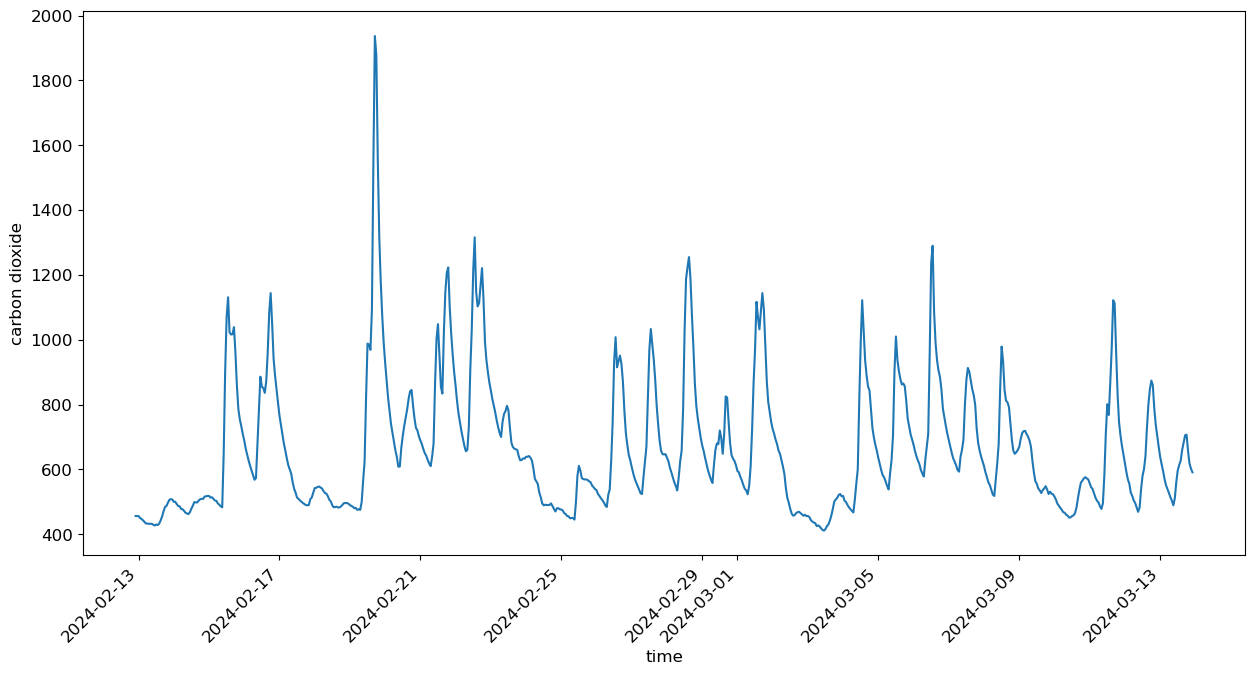

In [50]:
temperature.plot(y='carbon dioxide', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('time', fontsize=12)
plt.ylabel('carbon dioxide', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Create training and testing datasets

In [51]:
train_size = int(0.8 * len(df))

In [71]:
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

In [72]:
train_start_dt = train_df.index[0]
test_start_dt = test_df.index[0]

In [73]:
train_start_dt, test_start_dt

(Timestamp('2024-02-12 22:00:00'), Timestamp('2024-03-07 23:00:00'))

In [74]:
df

,CO2 (ppm),Humidity (%H),PM10 (μg/m³),PM2.5 (μg/m³),Temperature (°C),TVOC (ppm)
Time,,,,,,
2024-02-12 22:00:00,456,79.0,5.60,5.60,24.0,0.642
2024-02-12 23:00:00,456,79.0,5.25,5.13,24.1,0.711
2024-02-13 00:00:00,456,79.0,6.00,5.89,24.2,0.744
2024-02-13 01:00:00,450,79.0,6.44,6.33,24.2,0.759
2024-02-13 02:00:00,447,79.0,6.25,5.88,24.3,0.775
...,...,...,...,...,...,...
2024-03-13 18:00:00,707,77.7,16.20,15.30,23.3,0.497
2024-03-13 19:00:00,657,78.0,20.20,19.50,23.2,0.423
2024-03-13 20:00:00,618,78.4,23.20,22.00,23.5,0.375


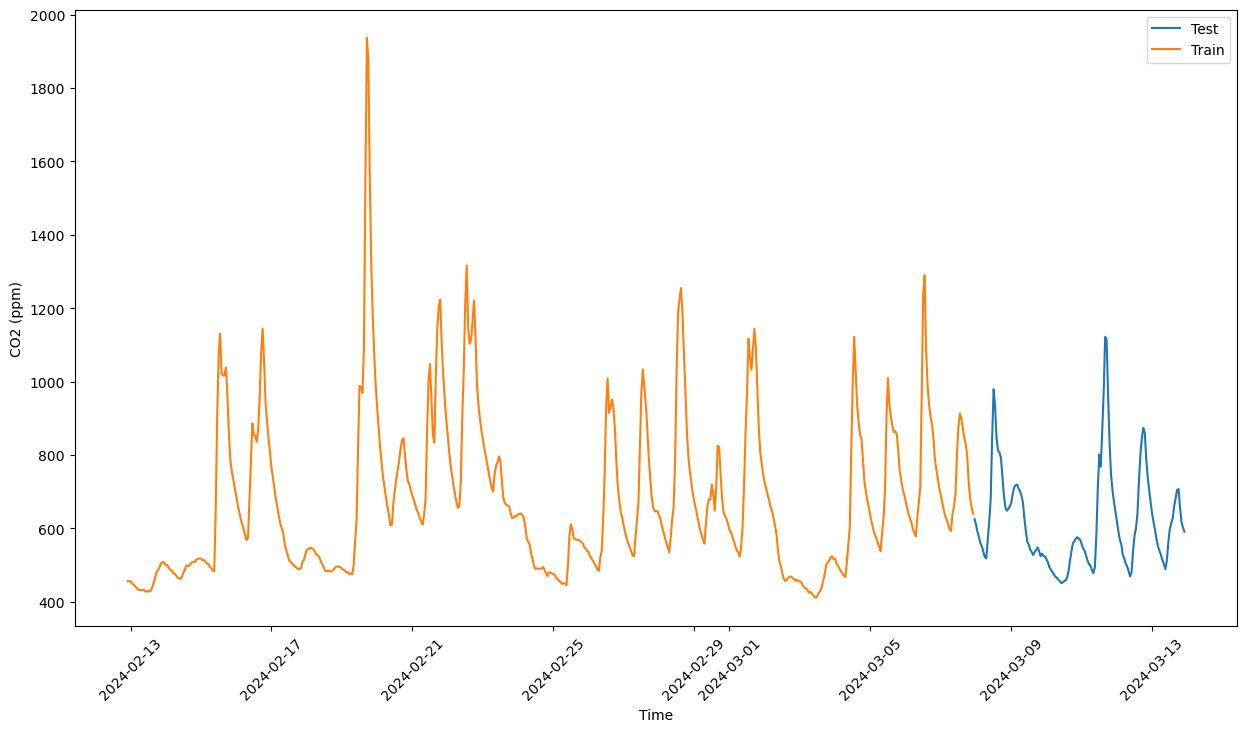

In [76]:
test_temperatures = df[df.index >= test_start_dt]["CO2 (ppm)"]
train_temperatures = df[(df.index < test_start_dt) & (df.index >= train_start_dt)]["CO2 (ppm)"]

plt.figure(figsize=(15, 8))
plt.plot(test_temperatures.index, test_temperatures.values, label='Test')

plt.plot(train_temperatures.index, train_temperatures.values, label='Train')

plt.xlabel('Time')
plt.ylabel('CO2 (ppm)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Data preparation

In [77]:
train_temperatures_reshaped = train_temperatures.values.reshape(-1, 1)
test_temperatures_reshaped = test_temperatures.values.reshape(-1, 1)

In [78]:
print("Training data shape: ", train_temperatures.shape)
print("Test data shape: ", test_temperatures.shape)

Training data shape:  (575,)
Test data shape:  (144,)


In [81]:
scaler = MinMaxScaler()
train_temperatures_scaled = scaler.fit_transform(train_temperatures_reshaped)
train_temperatures_scaled = pd.DataFrame(train_temperatures_scaled.flatten(), index=train_temperatures.index, columns=["CO2 (ppm)"])
train_temperatures_scaled.head(10)

,CO2 (ppm)
Time,
2024-02-12 22:00:00,0.029489
2024-02-12 23:00:00,0.029489
2024-02-13 00:00:00,0.029489
2024-02-13 01:00:00,0.025557
2024-02-13 02:00:00,0.023591
2024-02-13 03:00:00,0.020970
2024-02-13 04:00:00,0.017693
2024-02-13 05:00:00,0.014417
2024-02-13 06:00:00,0.014417


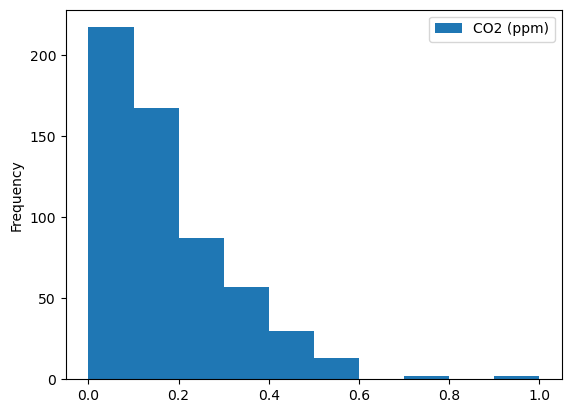

In [82]:
train_temperatures_scaled.plot.hist(bins=10)
plt.show()

In [83]:
test_temperatures_scaled = scaler.fit_transform(test_temperatures_reshaped)
test_temperatures_scaled = pd.DataFrame(test_temperatures_scaled.flatten(), index=test_temperatures.index, columns=["CO2 (ppm)"])
test_temperatures_scaled.head(10)

,CO2 (ppm)
Time,
2024-03-07 23:00:00,0.259314
2024-03-08 00:00:00,0.236960
2024-03-08 01:00:00,0.208644
2024-03-08 02:00:00,0.186289
2024-03-08 03:00:00,0.162444
2024-03-08 04:00:00,0.149031
2024-03-08 05:00:00,0.126677
2024-03-08 06:00:00,0.105812
2024-03-08 07:00:00,0.099851


In [147]:
HORIZON = 1

In [148]:
stepwise_fit_temp = auto_arima(train_temperatures_scaled, trace=True, suppress_warnings=True)
stepwise_fit_temp.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-2393.419, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-599.976, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2028.770, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1304.737, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-71.421, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-2389.218, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-2389.436, Time=0.09 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-2389.165, Time=0.17 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-2391.036, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2329.457, Time=0.07 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-2395.796, Time=0.13 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-2078.270, Time=0.13 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-2394.567, Time=0.24 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-1788.481, Time=0.07 sec
 ARIMA(0,0,4)(0,0,0)[0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  575
Model:               SARIMAX(1, 0, 3)   Log Likelihood                1203.898
Date:                Thu, 14 Mar 2024   AIC                          -2395.796
Time:                        18:41:17   BIC                          -2369.669
Sample:                             0   HQIC                         -2385.606
                                - 575                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0237      0.008      3.123      0.002       0.009       0.039
ar.L1          0.8639      0.020     42.199      0.000       0.824       0.904
ma.L1          0.9396      0.021     44.204      0.000       0.898       0.981
ma.L2          0.4972      0.038     12.928      0.000       0.422       0.573
ma.L3          0.1444      0.034      4.261      0.000       0.078       0.211
sigma2         0.0009   2.13e-05     41.418      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              6630.20
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                             1.95
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [149]:
order = (1,0,3)

In [150]:
model_temp =  ARIMA(train_temperatures_scaled, order=order)
result_temp = model_temp.fit()

print(result_temp.summary())

                               SARIMAX Results                                
Dep. Variable:              CO2 (ppm)   No. Observations:                  575
Model:                 ARIMA(1, 0, 3)   Log Likelihood                1203.898
Date:                Thu, 14 Mar 2024   AIC                          -2395.795
Time:                        18:41:17   BIC                          -2369.669
Sample:                             0   HQIC                         -2385.606
                                - 575                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1738      0.036      4.781      0.000       0.103       0.245
ar.L1          0.8640      0.020     42.207      0.000       0.824       0.904
ma.L1          0.9392      0.021     44.175      0.0

Walk-forward validation

Create a test data point for each HORIZON.<br>
Shift the data horizontally according to its horizon point.

In [151]:
test_temp_shifted = test_temperatures_scaled.copy()

for t in range(1, HORIZON):
    test_temp_shifted["CO2 (ppm)+" + str(t)] = test_temp_shifted["CO2 (ppm)"].shift(-t, freq='H')
    
test_temp_shifted = test_temp_shifted.dropna(how='any')
test_temp_shifted.head()

,CO2 (ppm)
Time,
2024-03-07 23:00:00,0.259314
2024-03-08 00:00:00,0.236960
2024-03-08 01:00:00,0.208644
2024-03-08 02:00:00,0.186289
2024-03-08 03:00:00,0.162444


Make predictions on the test data using a sliding window approach in a loop the size of the test data length.

In [152]:
stepwise_fit_temp_test = auto_arima(test_temperatures_scaled, trace=True, suppress_warnings=True)
stepwise_fit_temp_test.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-493.955, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-51.452, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-379.626, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-227.218, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=81.950, Time=0.00 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-492.668, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-492.810, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-490.552, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-492.084, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-465.362, Time=0.03 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-494.029, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-427.052, Time=0.04 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-492.028, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-348.433, Time=0.04 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(1, 0, 3)   Log Likelihood                 253.014
Date:                Thu, 14 Mar 2024   AIC                           -494.029
Time:                        18:41:24   BIC                           -476.210
Sample:                    03-07-2024   HQIC                          -486.788
                         - 03-13-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0427      0.027      1.595      0.111      -0.010       0.095
ar.L1          0.8276      0.049     16.962      0.000       0.732       0.923
ma.L1          1.0707      0.066     16.175      0.000       0.941       1.200
ma.L2          0.6614      0.079      8.355      0.000       0.506       0.817
ma.L3          0.1678      0.059      2.865      0.004       0.053       0.283
sigma2         0.0017      0.000     16.118      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1194.57
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                             2.49
Prob(H) (two-sided):                  0.01   Kurtosis:                        16.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [153]:
test_temp_shifted

,CO2 (ppm)
Time,
2024-03-07 23:00:00,0.259314
2024-03-08 00:00:00,0.236960
2024-03-08 01:00:00,0.208644
2024-03-08 02:00:00,0.186289
2024-03-08 03:00:00,0.162444
...,...
2024-03-13 18:00:00,0.381520
2024-03-13 19:00:00,0.307004
2024-03-13 20:00:00,0.248882


In [154]:
%%time
training_window = 24

train_ts = train_temperatures_scaled["CO2 (ppm)"]
test_ts = test_temp_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions_temp = list()

order = (2, 0, 0)

for t in range(test_ts.shape[0]):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions_temp.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2024-03-07 23:00:00
1 : predicted = [0.14775066] expected = [0.2593144560357675]
2024-03-08 00:00:00
2 : predicted = [0.32607429] expected = [0.23695976154992549]
2024-03-08 01:00:00
3 : predicted = [0.22372402] expected = [0.20864381520119224]
2024-03-08 02:00:00
4 : predicted = [0.1978125] expected = [0.1862891207153502]
2024-03-08 03:00:00
5 : predicted = [0.18140257] expected = [0.16244411326378538]
2024-03-08 04:00:00
6 : predicted = [0.16118661] expected = [0.1490312965722802]
2024-03-08 05:00:00
7 : predicted = [0.15452982] expected = [0.12667660208643816]
2024-03-08 06:00:00
8 : predicted = [0.13160447] expected = [0.105812220566319]
2024-03-08 07:00:00
9 : predicted = [0.11219132] expected = [0.0998509687034278]
2024-03-08 08:00:00
10 : predicted = [0.11450999] expected = [0.1743666169895678]
2024-03-08 09:00:00
11 : predicted = [0.21619002] expected = [0.2488822652757079]
2024-03-08 10:00:00
12 : predicted = [0.27907962] expected = [0.33979135618479883]
2024-03-08 11:00:00
13

2024-03-12 09:00:00
107 : predicted = [0.06477602] expected = [0.026825633383010472]
2024-03-12 10:00:00
108 : predicted = [0.04249468] expected = [0.046199701937406856]
2024-03-12 11:00:00
109 : predicted = [0.08800731] expected = [0.12965722801788382]
2024-03-12 12:00:00
110 : predicted = [0.21262022] expected = [0.1922503725782415]
2024-03-12 13:00:00
111 : predicted = [0.25624018] expected = [0.2235469448584203]
2024-03-12 14:00:00
112 : predicted = [0.25762818] expected = [0.28315946348733234]
2024-03-12 15:00:00
113 : predicted = [0.33514929] expected = [0.41281669150521616]
2024-03-12 16:00:00
114 : predicted = [0.52074667] expected = [0.5201192250372578]
2024-03-12 17:00:00
115 : predicted = [0.6324193] expected = [0.5901639344262296]
2024-03-12 18:00:00
116 : predicted = [0.65744506] expected = [0.6304023845007453]
2024-03-12 19:00:00
117 : predicted = [0.65702308] expected = [0.609538002980626]
2024-03-12 20:00:00
118 : predicted = [0.5643319] expected = [0.5022354694485843]


Compare the prediction against the actual Temperature.

In [155]:
eval_df = pd.DataFrame(predictions_temp, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['Timestamp'] = test_temperatures_scaled.index[0:len(test_temperatures_scaled.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='Timestamp', value_name='Prediction', var_name='H')
eval_df['Actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['Prediction', 'Actual']] = scaler.inverse_transform(eval_df[['Prediction', 'Actual']])
eval_df.head()

,Timestamp,H,Prediction,Actual
0,2024-03-07 23:00:00,t+1,550.140694,625.0
1,2024-03-08 00:00:00,t+1,669.795850,610.0
2,2024-03-08 01:00:00,t+1,601.118814,591.0
3,2024-03-08 02:00:00,t+1,583.732190,576.0
4,2024-03-08 03:00:00,t+1,572.721124,560.0


Check the model accuracy by testing its mean absolute percentage error (MAPE) over all the predictions.

In [156]:
if (HORIZON > 1):
    eval_df['APE'] = (eval_df['Prediction'] - eval_df['Actual']).abs()
    print(eval_df.groupby('H')['APE'].mean())

In [157]:
# Mean absolute percentage error
def mape(predictions, actuals):
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    return (np.absolute(predictions - actuals) / actuals).mean()

In [158]:
print('Multi-step forecast MAPE: ', mape(eval_df['Prediction'], eval_df['Actual'])*100, '%')

Multi-step forecast MAPE:  3.0568819843387907 %


In [159]:
rmse_temp = sqrt(mean_squared_error(eval_df['Prediction'], eval_df['Actual']))
rmse_temp

36.289028351905536

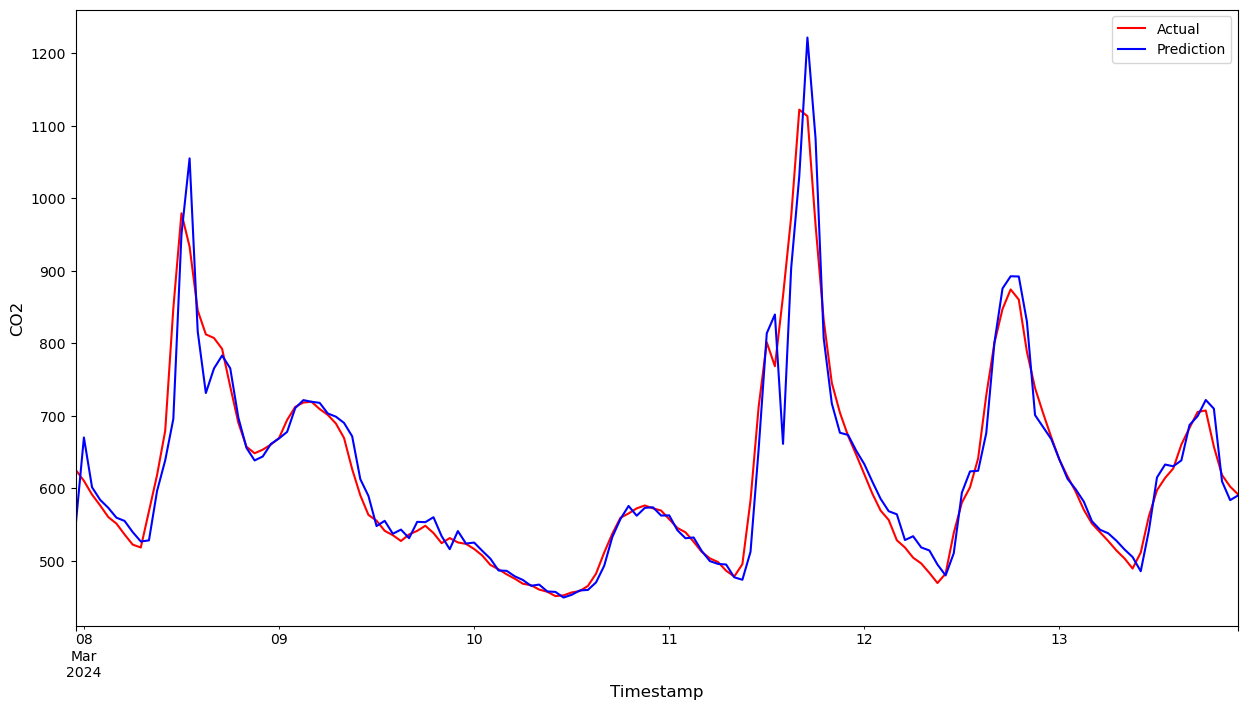

In [160]:
if HORIZON == 1:
    eval_df.plot(x='Timestamp', y=['Actual', 'Prediction'], style=['r', 'b'], figsize=(15, 8))
    plt.xlabel('Timestamp', fontsize=12)
    plt.ylabel('CO2', fontsize=12)
    plt.legend(['Actual', 'Prediction'], loc='best')
    plt.show()
else:
    plot_df = eval_df[(eval_df.H == 't+1')][['Timestamp', 'Actual']]
    for t in range(1, HORIZON + 1):
        plot_df['t+' + str(t)] = eval_df[(eval_df.H == 't+' + str(t))]['Prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.plot(plot_df['Timestamp'], plot_df['Actual'], color='red', linewidth=4.0, label='Actual')  # Specify label for actual data
    for t in range(1, HORIZON + 1):
        x = plot_df['Timestamp'][(t - 1):]
        y = plot_df['t+' + str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4 * math.pow(.9, t), alpha=math.pow(0.8, t),
                label='Prediction t+' + str(t))

    ax.legend(loc='best')
    plt.xlabel('Timestamp', fontsize=12)
    plt.ylabel('CO2', fontsize=12)
    plt.show()

In [161]:
next_hour = pd.date_range(start=df.index[-1], periods=2, freq='H')[-1]

In [162]:
pred_temp = model_fit.predict(start=len(df), end=len(df), typ="levels")[0]
pred_temp_scaled = round(scaler.inverse_transform(np.array(pred_temp).reshape(-1, 1))[0][0], 1)
print(f"{next_hour} {pred_temp_scaled}")

2024-03-13 23:00:00 609.4
